In [1]:
#Import all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import seaborn as sns
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem, FixedMount, Array
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
import datetime
import pytz
import os
import gc
import itertools
import inspect
import calendar
import h5py
from pvlib import pvsystem, location, modelchain, iotools,tools
import pathlib
from dataclasses import dataclass
from pvlib import tracking
from netCDF4 import num2date
from requests.exceptions import HTTPError
from xml.etree.ElementTree import ParseError
from pvlib.irradiance import campbell_norman, get_extra_radiation, disc, louche, erbs_driesse, ghi_from_poa_driesse_2023
from pvlib.irradiance import _liujordan, get_total_irradiance
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import warnings
from pvlib._deprecation import deprecated

In [2]:
#BSRN QC
data_path ='TUKS_2018_CS.csv'
df = pd.read_csv(data_path, index_col=[0], parse_dates=[0])
original_entries = df.shape[0]
df.head(2)  

,ghi,dhi,dni,tcc,ghi_cs,dhi_cs,dni_cs
DATE,,,,,,,
2018-01-01 00:00:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN
2018-01-01 00:01:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN


In [3]:
ghi=df['ghi']
dhi=df['dhi']
dni=df['dni']
ghi_cs=df['ghi_cs']
dhi_cs=df['dhi_cs']
dni_cs=df['dni_cs']
tcc=df['tcc']

In [4]:
latitude=-25.75; longitude=28.23; altitude=1410; tz='Africa/Johannesburg'
location = Location(latitude,longitude,name='Tuks', altitude=1410, tz=tz)
datetime_or_doy=df.index
times=df.index
times

DatetimeIndex(['2018-01-01 00:00:00+02:00', '2018-01-01 00:01:00+02:00',
               '2018-01-01 00:02:00+02:00', '2018-01-01 00:03:00+02:00',
               '2018-01-01 00:04:00+02:00', '2018-01-01 00:05:00+02:00',
               '2018-01-01 00:06:00+02:00', '2018-01-01 00:07:00+02:00',
               '2018-01-01 00:08:00+02:00', '2018-01-01 00:09:00+02:00',
               ...
               '2018-12-31 23:50:00+02:00', '2018-12-31 23:51:00+02:00',
               '2018-12-31 23:52:00+02:00', '2018-12-31 23:53:00+02:00',
               '2018-12-31 23:54:00+02:00', '2018-12-31 23:55:00+02:00',
               '2018-12-31 23:56:00+02:00', '2018-12-31 23:57:00+02:00',
               '2018-12-31 23:58:00+02:00', '2018-12-31 23:59:00+02:00'],
              dtype='datetime64[ns, UTC+02:00]', name='DATE', length=525600, freq=None)

In [5]:
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
apparent_zenith = solpos['apparent_zenith']
zenith = solpos['zenith']
solar_zenith=solpos['apparent_zenith']
azimuth = solpos['azimuth']
equation_of_time=solpos['equation_of_time']
cos_solar_zenith=tools.cosd(solar_zenith)
pressure = pvlib.atmosphere.alt2pres(altitude)
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude,longitude)
apparent_elevation = solpos['apparent_elevation']
dni_extra=pvlib.irradiance.get_extra_radiation(times, solar_constant=1367, method='spencer', epoch_year=2018)
airmass_relative=pvlib.atmosphere.get_relative_airmass(apparent_zenith, model='gueymard2003')
absolute_airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ghi,525599.0,232.760527,331.450946,0.000000,0.000000,2.376200,431.692500,1514.740000
dhi,525388.0,67.610387,105.720273,0.000000,0.000000,2.198960,98.255250,1012.260000
dni,525271.0,262.754704,375.704679,0.000000,0.000000,0.000000,644.171000,1108.180000
tcc,525600.0,30.846575,34.817341,0.000000,0.000000,16.000000,55.000000,100.000000
ghi_cs,264181.0,564.661483,327.405432,0.000568,288.597189,597.289252,832.602518,1116.008603
dhi_cs,264181.0,86.409265,41.856082,0.000410,55.047015,92.584181,120.091690,152.939196
dni_cs,264181.0,771.301138,216.942312,13.461820,731.024903,850.142513,910.766605,964.117418


In [7]:
df['zenith']=zenith
df['solar_zenith']=solar_zenith
df['cos_solar_zenith']=cos_solar_zenith
df['dni_extra']=dni_extra
df['ghi_extra'] = dni_extra * cos_solar_zenith
df['equation_of_time']=equation_of_time
hour_angle=pvlib.solarposition.hour_angle(times, longitude, equation_of_time)
df['hour_angle']=hour_angle
ast = hour_angle / 15 + 12
ast[ast < 0] = abs(ast[ast < 0])
df['ast']=ast
df['airmass']=airmass_relative

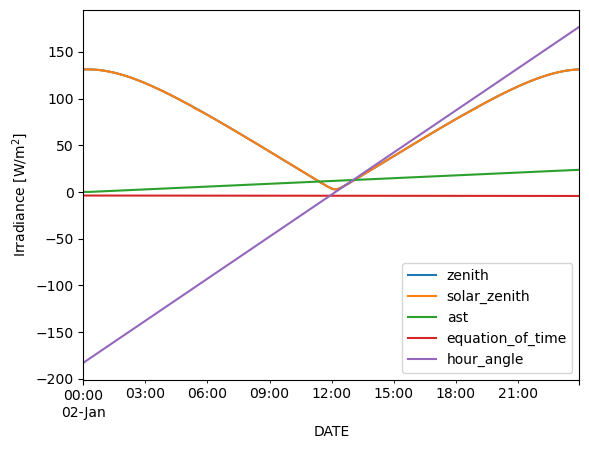

In [8]:
df.loc['2018-01-02', ['zenith','solar_zenith','ast','equation_of_time','hour_angle']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [9]:
df['kn']=df['dni']/df['dni_extra'] #beam fraction
df['k_t']=df['ghi']/df['ghi_extra']  # clearness index
df['k_d']=df['dhi']/df['ghi'] # diffuse fraction
df['k_tcsi'] = df['ghi'] / df['ghi_cs'] #cloud_enhancement_estimate= df['ghi'] - df['ghi_clear']
df['k_tc'] = df['ghi_cs'] / df['ghi_extra']  #k_tc is the clear-sky clearness index = ghi,cs/e_exth.
df['dk_tc'] = df['k_tc'] - df['k_t'] #deviation of kt from k_tc #clearness index deviation #delta_kc
df['k_de'] = np.maximum(0,1-df['ghi_cs']/df['ghi']) #Proportion of kd attributable to cloud enhancement #cloud_enhancement_estimate / df['ghi']
df['k_tprime'] = df['k_t']/(1.031*np.exp(-1.4/(0.9+9.4*df['airmass']))+0.1) 
df.columns

Index(['ghi', 'dhi', 'dni', 'tcc', 'ghi_cs', 'dhi_cs', 'dni_cs', 'zenith',
       'solar_zenith', 'cos_solar_zenith', 'dni_extra', 'ghi_extra',
       'equation_of_time', 'hour_angle', 'ast', 'airmass', 'kn', 'k_t', 'k_d',
       'k_tcsi', 'k_tc', 'dk_tc', 'k_de', 'k_tprime'],
      dtype='object')

In [10]:
df['K_t'] = df.groupby([df.index.get_level_values('DATE').floor('H')])['k_t'].transform('mean') #Kt_hourly
df['K_tdaily'] = df.groupby([df.index.get_level_values('DATE').date])['k_t'].transform('mean')  #Kt_daily

C:\Users\User\AppData\Local\Temp\ipykernel_32620\3307218359.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['K_t'] = df.groupby([df.index.get_level_values('DATE').floor('H')])['k_t'].transform('mean') #Kt_hourly


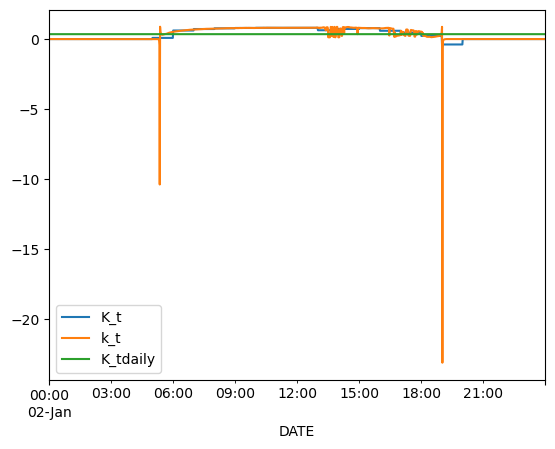

In [11]:
df.loc['2018-01-02', ['K_t','k_t','K_tdaily']].plot()
plt.legend()

In [12]:
# Calculate VI for each minute
rho = df['ghi'] / df['ghi_cs']
rho_minus1 = rho.shift(1)
rho_plus1 = rho.shift(-1)
VI = np.sqrt(((rho - rho_minus1.fillna(rho_plus1)) ** 2 + (rho - rho_plus1.fillna(rho_minus1)) ** 2) / 2)
VI[rho_minus1.isna() & np.invert(rho_plus1.isna())] = np.abs(rho - rho_plus1)
VI[rho_plus1.isna() & np.invert(rho_minus1.isna())] = np.abs(rho - rho_minus1)
VI[rho_minus1.isna() & rho_plus1.isna()] = np.where(rho<1.04,0.021+0.397*rho-0.231*rho**2-0.13*np.exp(-(((rho-0.931)/0.134)**2)**0.834),0.12+0.65*(rho-1.04))
df['VI_s'] = VI

In [13]:
ktprime = df['k_tprime']
ktprime_m1 = ktprime.shift(1)
ktprime_p1 = ktprime.shift(-1)

# Calculate VI_perez for each minute
VI_perez = 0.5 * (abs(ktprime - ktprime_m1.fillna(ktprime_p1)) + abs(ktprime - ktprime_p1.fillna(ktprime_m1)))

VI_perez[ktprime_m1.isna() & ktprime_p1.isna()] = 0
df['VI_p'] = VI_perez

In [14]:
df['persistence'] = np.nanmean([df['k_t'].shift(), df['k_t'].shift(-1)],axis=0) #persistence
df.head()

,ghi,dhi,dni,tcc,ghi_cs,dhi_cs,dni_cs,zenith,solar_zenith,cos_solar_zenith,...,k_tcsi,k_tc,dk_tc,k_de,k_tprime,K_t,K_tdaily,VI_s,VI_p,persistence
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN,131.161493,131.161493,-0.658184,...,NaN,NaN,NaN,NaN,NaN,0.0,0.404621,NaN,0.0,0.0
2018-01-01 00:01:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN,131.173397,131.173397,-0.658340,...,NaN,NaN,NaN,NaN,NaN,0.0,0.404621,NaN,0.0,0.0
2018-01-01 00:02:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN,131.184103,131.184103,-0.658481,...,NaN,NaN,NaN,NaN,NaN,0.0,0.404621,NaN,0.0,0.0
2018-01-01 00:03:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN,131.193610,131.193610,-0.658606,...,NaN,NaN,NaN,NaN,NaN,0.0,0.404621,NaN,0.0,0.0
2018-01-01 00:04:00+02:00,0.0,0.0,0.0,4,NaN,NaN,NaN,131.201919,131.201919,-0.658715,...,NaN,NaN,NaN,NaN,NaN,0.0,0.404621,NaN,0.0,0.0


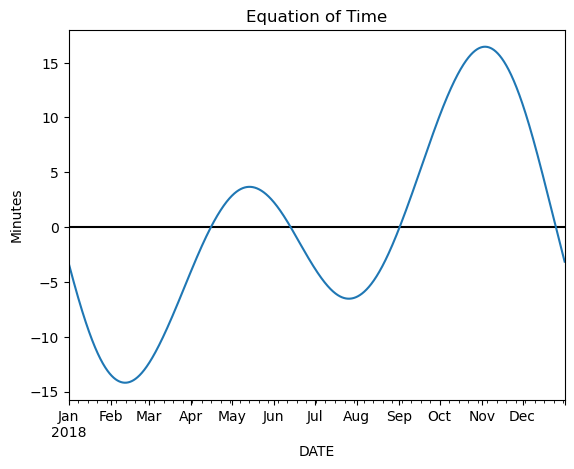

In [15]:
fig, ax1 = plt.subplots()
ax1 = solpos['equation_of_time'].plot(zorder=2)
ax1.hlines(0, solpos.index[0], solpos.index[-1], color='black', zorder=1)
ax1.set_ylabel('Minutes')
plt.title('Equation of Time')
plt.show()

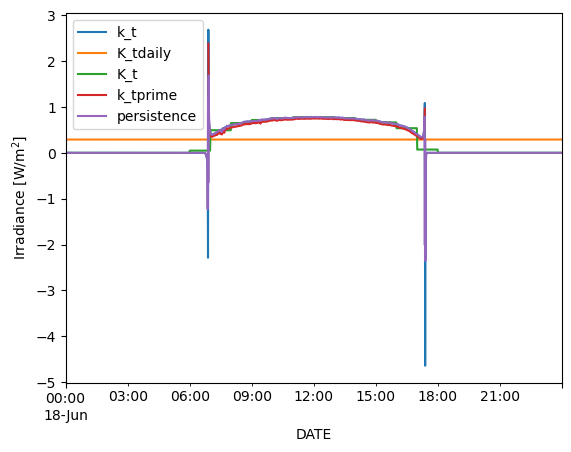

In [16]:
df.loc['2018-06-18', ['k_t','K_tdaily','K_t','k_tprime','persistence']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [17]:
(C, b0, b1, b2, b3, b4, b5) = (0.042336, -3.7912, 7.5479, -0.010036, 0.003148, -5.3146, 1.7073)
df['kd_Engerer2'] = np.minimum(1, C + (1-C)/ (1 + np.exp(b0 + b1*df.k_t + b2*df.ast + b3*df.zenith + b4*df.dk_tc)) + b5*df.k_de)
df['dhi_Engerer2']=df['kd_Engerer2']*df['ghi']
df['dni_Engerer2'] = (df['ghi']-df['dhi_Engerer2']) / cos_solar_zenith 

E:\anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
df['kd_Engerer2H'] = df.groupby([df.index.get_level_values('DATE').floor('H')])['kd_Engerer2'].transform('mean') #ENG2_kd_hourly

C:\Users\User\AppData\Local\Temp\ipykernel_32620\1458380980.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['kd_Engerer2H'] = df.groupby([df.index.get_level_values('DATE').floor('H')])['kd_Engerer2'].transform('mean') #ENG2_kd_hourly


In [19]:
df = df[df['zenith'] < 85]

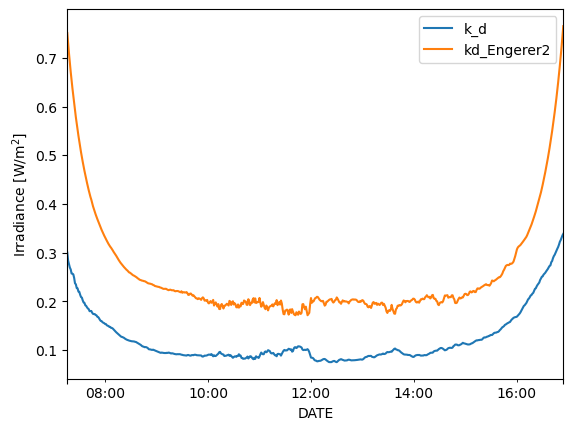

In [20]:
df.loc['2018-06-03', ['k_d','kd_Engerer2']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

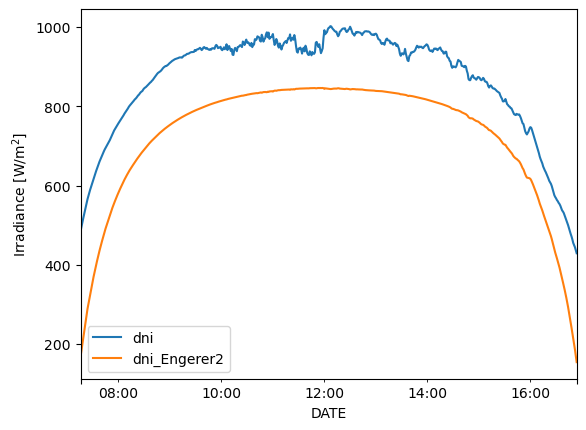

In [21]:
df.loc['2018-06-03', ['dni','dni_Engerer2']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

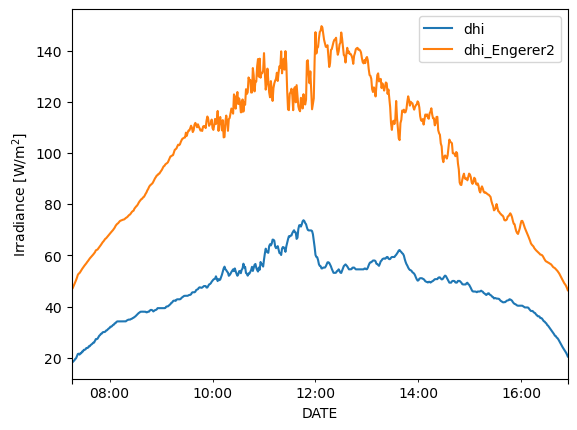

In [22]:
df.loc['2018-06-03', ['dhi','dhi_Engerer2']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [23]:
df.columns

Index(['ghi', 'dhi', 'dni', 'tcc', 'ghi_cs', 'dhi_cs', 'dni_cs', 'zenith',
       'solar_zenith', 'cos_solar_zenith', 'dni_extra', 'ghi_extra',
       'equation_of_time', 'hour_angle', 'ast', 'airmass', 'kn', 'k_t', 'k_d',
       'k_tcsi', 'k_tc', 'dk_tc', 'k_de', 'k_tprime', 'K_t', 'K_tdaily',
       'VI_s', 'VI_p', 'persistence', 'kd_Engerer2', 'dhi_Engerer2',
       'dni_Engerer2', 'kd_Engerer2H'],
      dtype='object')

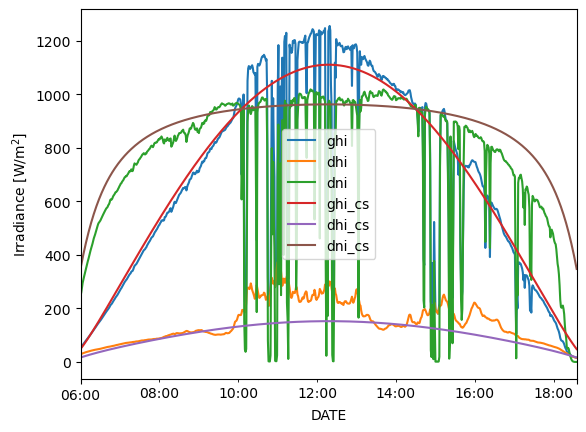

In [24]:
#It is often helpful to visualize the data in order to check that the measurements are within the expected ones. 
df.loc['2018-01-18', ['ghi','dhi','dni','ghi_cs','dhi_cs','dni_cs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

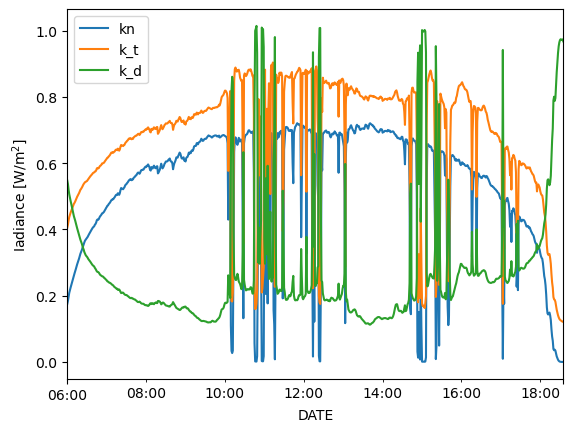

In [25]:
df.loc['2018-01-18', ['kn','k_t','k_d']].plot()
plt.ylabel('Iadiance [W/m$^2$]')
plt.legend()

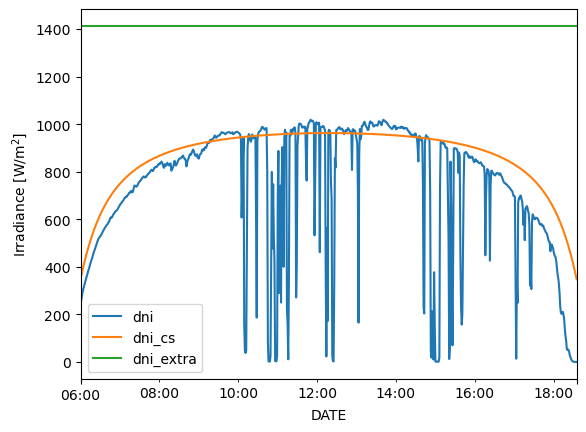

In [26]:
df.loc['2018-01-18', ['dni','dni_cs','dni_extra']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

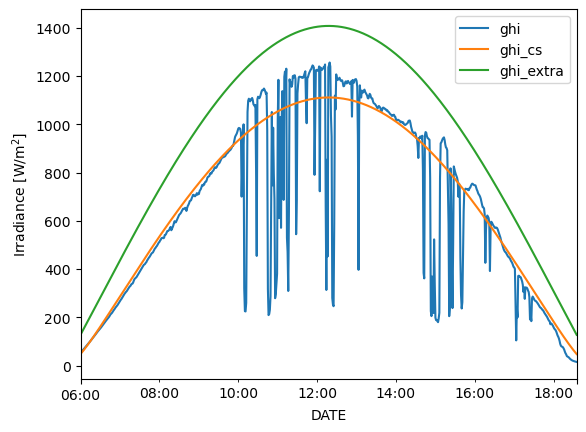

In [27]:
df.loc['2018-01-18', ['ghi','ghi_cs','ghi_extra']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

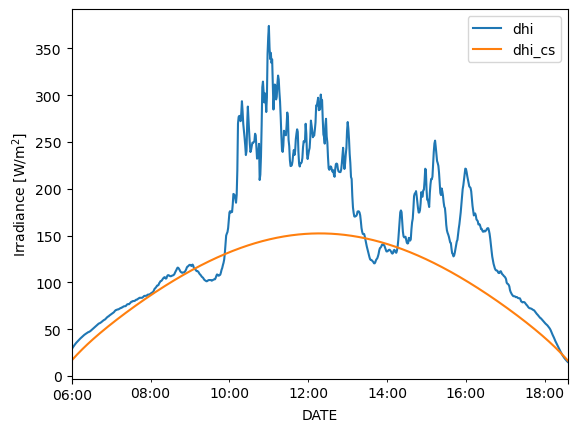

In [28]:
df.loc['2018-01-18', ['dhi','dhi_cs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [29]:
df.columns

Index(['ghi', 'dhi', 'dni', 'tcc', 'ghi_cs', 'dhi_cs', 'dni_cs', 'zenith',
       'solar_zenith', 'cos_solar_zenith', 'dni_extra', 'ghi_extra',
       'equation_of_time', 'hour_angle', 'ast', 'airmass', 'kn', 'k_t', 'k_d',
       'k_tcsi', 'k_tc', 'dk_tc', 'k_de', 'k_tprime', 'K_t', 'K_tdaily',
       'VI_s', 'VI_p', 'persistence', 'kd_Engerer2', 'dhi_Engerer2',
       'dni_Engerer2', 'kd_Engerer2H'],
      dtype='object')

In [30]:
df = df[df['k_d'] < 1]
df = df[df['persistence'] < 1]

In [31]:
feature_names = ['k_d','k_t','k_tcsi', 'k_tc', 'dk_tc','k_de', 'k_tprime', 'K_t', 'K_tdaily','zenith','ast','airmass','VI_s', 'VI_p','persistence', 'kd_Engerer2','ghi_cs','kd_Engerer2H']
df_features = df[feature_names]
df_features = df_features.sort_index()
df_features.head()

,k_d,k_t,k_tcsi,k_tc,dk_tc,k_de,k_tprime,K_t,K_tdaily,zenith,ast,airmass,VI_s,VI_p,persistence,kd_Engerer2,ghi_cs,kd_Engerer2H
DATE,,,,,,,,,,,,,,,,,,
2018-01-01 05:48:00+02:00,0.364179,0.426889,1.130056,0.377759,-0.049130,0.115088,0.382591,0.235357,0.404621,84.920011,5.625316,9.920309,0.007574,0.007655,0.426689,0.740888,48.802286,0.858969
2018-01-01 05:49:00+02:00,0.354458,0.435047,1.122627,0.387525,-0.047521,0.109232,0.390071,0.235357,0.404621,84.712942,5.641977,9.611517,0.008607,0.006869,0.434362,0.718409,51.991628,0.858969
2018-01-01 05:50:00+02:00,0.347748,0.441835,1.112984,0.396983,-0.044853,0.101514,0.396329,0.235357,0.404621,84.505720,5.658639,9.319825,0.008101,0.006661,0.442280,0.696557,55.238445,0.858969
2018-01-01 05:51:00+02:00,0.339926,0.449514,1.106797,0.406140,-0.043375,0.096492,0.403392,0.235357,0.404621,84.298344,5.675300,9.043946,0.007552,0.006402,0.448774,0.676185,58.539363,0.858969
2018-01-01 05:52:00+02:00,0.333213,0.455713,1.098091,0.415005,-0.040708,0.089329,0.409134,0.235357,0.404621,84.090815,5.691961,8.782715,0.008660,0.005554,0.455502,0.656348,61.891209,0.858969


In [32]:
df[['k_d','k_t','k_tcsi', 'k_tc', 'dk_tc','k_de', 'k_tprime', 'K_t', 'K_tdaily','zenith','ast','airmass','VI_s', 'VI_p','persistence', 'kd_Engerer2']].to_csv('TUKS2018.csv')


In [33]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222465 entries, 2018-01-01 05:48:00+02:00 to 2018-12-31 18:33:00+02:00
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   k_d           222465 non-null  float64
 1   k_t           222465 non-null  float64
 2   k_tcsi        222465 non-null  float64
 3   k_tc          222465 non-null  float64
 4   dk_tc         222465 non-null  float64
 5   k_de          222465 non-null  float64
 6   k_tprime      222465 non-null  float64
 7   K_t           222465 non-null  float64
 8   K_tdaily      222465 non-null  float64
 9   zenith        222465 non-null  float64
 10  ast           222465 non-null  float64
 11  airmass       222465 non-null  float64
 12  VI_s          222465 non-null  float64
 13  VI_p          222465 non-null  float64
 14  persistence   222465 non-null  float64
 15  kd_Engerer2   222465 non-null  float64
 16  ghi_cs        222465 non-null  float64
 17  kd

In [34]:
print(df_features.describe().to_markdown())

|       |           k_d |              k_t |           k_tcsi |           k_tc |          dk_tc |           k_de |        k_tprime |           K_t |      K_tdaily |       zenith |          ast |      airmass |             VI_s |             VI_p |      persistence |   kd_Engerer2 |      ghi_cs |   kd_Engerer2H |
|:------|--------------:|-----------------:|-----------------:|---------------:|---------------:|---------------:|----------------:|--------------:|--------------:|-------------:|-------------:|-------------:|-----------------:|-----------------:|-----------------:|--------------:|------------:|---------------:|
| count | 222465        | 222465           | 222465           | 222465         | 222465         | 222465         | 222465          | 222465        | 222465        | 222465       | 222465       | 222465       | 222465           | 222465           | 222465           | 222465        | 222465      |  222465        |
| mean  |      0.373344 |      0.620628    |      0.865819